In [12]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Verification of the drive path
# the image in the drive is sample.png
import os
drive_path = "/content/drive/MyDrive/"
print(f"Drive path exists: {os.path.exists(drive_path)}")
print(f"Sample image exists: {os.path.exists(drive_path + 'sample.png')}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive path exists: True
Sample image exists: True


In [13]:
# Install the requirements
!nvidia-smi
!apt-get update
!apt-get install -y libopencv-dev

Wed Dec 11 14:02:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [50]:
# CPU grayscaling and blurring
# For imread/imwrite using openCV because of optimization (the time would be solely on the processing of the images for grayscale and blur)
# I/O would be constant factor for the comparison
%%writefile image_processor.cpp
#include <opencv2/opencv.hpp>
#include <chrono>
#include <iostream>
#include <vector>

using namespace std;
using namespace cv;
using namespace std::chrono;

Mat convertToGrayscale(const Mat& input) {
    Mat output = Mat::zeros(input.size(), CV_32F);
    for(int y = 0; y < input.rows; y++) {
        for(int x = 0; x < input.cols; x++) {
            Vec3b pixel = input.at<Vec3b>(y, x);
            output.at<float>(y, x) =
                0.299f * pixel[0] +
                0.587f * pixel[1] +
                0.114f * pixel[2];
        }
    }
    return output;
}

Mat applyBlurCPU(const Mat& input) {
    Mat output = Mat::zeros(input.size(), input.type());

    const float kernel[5][5] = {
        {1.0f,    4.0f,     6.0f,     4.0f,    1.0f},
        {4.0f,  128.0f,   192.0f,   128.0f,    4.0f},
        {6.0f,  192.0f,   512.0f,   192.0f,    6.0f},
        {4.0f,  128.0f,   192.0f,   128.0f,    4.0f},
        {1.0f,    4.0f,     6.0f,     4.0f,    1.0f}
    };
    const float kernelSum = 2048.0f;

    for(int y = 0; y < input.rows; y++) {
        for(int x = 0; x < input.cols; x++) {
            float sum = 0.0f;

            for(int ky = -2; ky <= 2; ky++) {
                for(int kx = -2; kx <= 2; kx++) {
                    int ix = min(max(x + kx, 0), input.cols - 1);
                    int iy = min(max(y + ky, 0), input.rows - 1);

                    sum += input.at<float>(iy, ix) * kernel[ky+2][kx+2];
                }
            }
            output.at<float>(y, x) = sum / kernelSum;
        }
    }
    return output;
}


void processAndBenchmark(const string& inputPath) {
    try {
        Mat image = imread(inputPath);
        if (image.empty()) {
            throw runtime_error("Failed to load image: " + inputPath);
        }
        cvtColor(image, image, COLOR_BGR2RGB);

        size_t imageSize = image.rows * image.cols;

        // Grayscale
        auto grayStart = high_resolution_clock::now();
        Mat grayscale = convertToGrayscale(image);
        auto grayEnd = high_resolution_clock::now();
        auto grayTime = duration_cast<microseconds>(grayEnd - grayStart);
        double grayTimeSeconds = grayTime.count() / 1e6;

        // Blur
        auto blurStart = high_resolution_clock::now();
        Mat blurred = applyBlurCPU(grayscale);
        auto blurEnd = high_resolution_clock::now();
        auto blurTime = duration_cast<microseconds>(blurEnd - blurStart);
        double blurTimeSeconds = blurTime.count() / 1e6;

        // Convert to 8-bit and save (default for openCV)
        Mat grayscale8U, blurred8U;
        grayscale.convertTo(grayscale8U, CV_8U);
        blurred.convertTo(blurred8U, CV_8U);

        bool graySuccess = imwrite("/content/drive/MyDrive/cpu_grayscale.png", grayscale8U);
        if (!graySuccess) {
            throw runtime_error("Failed to save grayscale image to drive");
        }

        bool blurSuccess = imwrite("/content/drive/MyDrive/cpu_blur.png", blurred8U);
        if (!blurSuccess) {
            throw runtime_error("Failed to save blurred image to drive");
        }

        cout << "CPU Benchmark Results:" << endl;
        cout << "Image size: " << imageSize << " pixels (" << image.rows << "x" << image.cols << ")" << endl;
        cout << "Grayscale conversion time: " << grayTimeSeconds << " seconds " << endl;
        cout << "Blur operation time: " << blurTimeSeconds << " seconds " << endl;
        cout << "Total time: " << (grayTimeSeconds + blurTimeSeconds) << " seconds" << endl;

    } catch (const exception& e) {
        cerr << "Error during processing: " << e.what() << endl;
    }
}

int main(int argc, char** argv) {
    if (argc != 2) {
        cout << "Usage: " << argv[0] << " <image_path>" << endl;
        return -1;
    }
    processAndBenchmark(argv[1]);
    return 0;
}

Overwriting image_processor.cpp


In [51]:
# Compile
!g++ -o image_processor image_processor.cpp $(pkg-config --cflags --libs opencv4)
print("Compilation complete")

Compilation complete


In [53]:
# Run
!./image_processor "/content/drive/MyDrive/sample.png"

CPU Benchmark Results:
Image size: 1334000 pixels (1334x1000)
Grayscale conversion time: 0.048924 seconds 
Blur operation time: 0.527219 seconds 
Total time: 0.576143 seconds


In [43]:
# CUDA version of the same process
# Run on python T4 (CPU runs on python CPU)
# For imread/imwrite using openCV because of optimization (the time would be solely on the processing of the images for grayscale and blur)
# I/O would be constant factor for the comparison
%%writefile image_processor.cu

#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>
#include <chrono>
#include <iostream>

using namespace std;
using namespace cv;
using namespace std::chrono;

// CUDA kernel for grayscale
__global__ void grayscaleKernel(const uchar3* input, float* output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        int idx = y * width + x;
        output[idx] = 0.299f * input[idx].x +
                      0.587f * input[idx].y +
                      0.114f * input[idx].z;
    }
}

// CUDA kernel for blur
__global__ void blurKernel(const float* input, float* output, int width, int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x < width && y < height) {
        const float kernel[5][5] = {
            {1.0f,    4.0f,     6.0f,     4.0f,    1.0f},
            {4.0f,  128.0f,   192.0f,   128.0f,    4.0f},
            {6.0f,  192.0f,   512.0f,   192.0f,    6.0f},
            {4.0f,  128.0f,   192.0f,   128.0f,    4.0f},
            {1.0f,    4.0f,     6.0f,     4.0f,    1.0f}
        };
        const float kernelSum = 2048.0f;

        float sum = 0.0f;
        for (int ky = -2; ky <= 2; ky++) {
            for (int kx = -2; kx <= 2; kx++) {
                int ix = min(max(x + kx, 0), width - 1);
                int iy = min(max(y + ky, 0), height - 1);
                sum += input[iy * width + ix] * kernel[ky+2][kx+2];
            }
        }
        output[y * width + x] = sum / kernelSum;
    }
}


void processImageGPU(const Mat& input) {
    int width = input.cols;
    int height = input.rows;
    size_t imageSize = width * height;

    uchar3* d_input;
    float* d_grayscale;
    float* d_blurred;
    cudaMalloc(&d_input, imageSize * sizeof(uchar3));
    cudaMalloc(&d_grayscale, imageSize * sizeof(float));
    cudaMalloc(&d_blurred, imageSize * sizeof(float));

    cudaMemcpy(d_input, input.data, imageSize * sizeof(uchar3), cudaMemcpyHostToDevice);

    dim3 blockSize(16, 16);
    dim3 gridSize((width + blockSize.x - 1) / blockSize.x,
                  (height + blockSize.y - 1) / blockSize.y);

    auto startGray = high_resolution_clock::now();
    grayscaleKernel<<<gridSize, blockSize>>>(d_input, d_grayscale, width, height);
    cudaDeviceSynchronize();
    auto endGray = high_resolution_clock::now();

    auto startBlur = high_resolution_clock::now();
    blurKernel<<<gridSize, blockSize>>>(d_grayscale, d_blurred, width, height);
    cudaDeviceSynchronize();
    auto endBlur = high_resolution_clock::now();

    Mat grayscaleResult(height, width, CV_32F);
    Mat blurredResult(height, width, CV_32F);

    cudaMemcpy(grayscaleResult.data, d_grayscale, imageSize * sizeof(float), cudaMemcpyDeviceToHost);
    cudaMemcpy(blurredResult.data, d_blurred, imageSize * sizeof(float), cudaMemcpyDeviceToHost);

    // Convert to 8-bit
    Mat grayscale8U, blurred8U;
    grayscaleResult.convertTo(grayscale8U, CV_8U);
    blurredResult.convertTo(blurred8U, CV_8U);

    imwrite("/content/drive/MyDrive/gpu_grayscale.png", grayscale8U);
    imwrite("/content/drive/MyDrive/gpu_blur.png", blurred8U);

    // Calculate and print timing
    auto grayTime = duration_cast<microseconds>(endGray - startGray);
    auto blurTime = duration_cast<microseconds>(endBlur - startBlur);
    double grayTimeSeconds = grayTime.count() / 1e6;
    double blurTimeSeconds = blurTime.count() / 1e6;

    cout << "GPU Benchmark Results:" << endl;
    cout << "Image size: " << imageSize << " pixels (" << width << "x" << height << ")" << endl;
    cout << "Grayscale conversion time: " << grayTimeSeconds << " seconds" << endl;
    cout << "Blur operation time: " << blurTimeSeconds << " seconds" << endl;
    cout << "Total GPU time: " << (grayTimeSeconds + blurTimeSeconds) << " seconds" << endl;

    cudaFree(d_input);
    cudaFree(d_grayscale);
    cudaFree(d_blurred);
}

int main(int argc, char** argv) {
    if (argc != 2) {
        cout << "Usage: " << argv[0] << " <image_path>" << endl;
        return -1;
    }

    Mat image = imread(argv[1]);
    if (image.empty()) {
        cerr << "Error: Could not read image." << endl;
        return -1;
    }

    processImageGPU(image);
    return 0;
}

Overwriting image_processor.cu


In [44]:
# Compile with included OpenCV libraries when compiling with NVCC. (Make sure OpenCV is installed through !apt-get update, !apt-get install -y libopencv-dev)
!nvcc -o image_processor_gpu image_processor.cu -I/usr/include/opencv4 -lopencv_core -lopencv_imgproc -lopencv_imgcodecs -lopencv_highgui -diag-suppress 611
print("Compilation complete")

Compilation complete


In [46]:
# Run
!./image_processor_gpu "/content/drive/MyDrive/sample.png"

GPU Benchmark Results:
Image size: 1334000 pixels (1000x1334)
Grayscale conversion time: 0.000267 seconds
Blur operation time: 0.000248 seconds
Total GPU time: 0.000515 seconds


In [48]:
#OpenCV - benchmark to see how the optimization GPU/CPU compares
from google.colab import drive
import os
import cv2
import time

img = cv2.imread('/content/drive/MyDrive/sample.png')

# Convert grayscale
start_time = time.time()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_time = time.time() - start_time


#Gaussian blur
start_time = time.time()
blurred = cv2.GaussianBlur(gray, (5,5), 0)
blur_time = time.time() - start_time

print("OpenCV Benchmark Results:")
print(f"Image size: {img.shape[0] * img.shape[1]} pixels ({img.shape[1]}x{img.shape[0]})")
print(f"Grayscale conversion time: {gray_time} seconds")
print(f"Blur operation time: {blur_time} seconds")
print(f"Total OpenCV time: {gray_time + blur_time} seconds")

cv2.imwrite('/content/drive/MyDrive/opencv_grayscale.png', gray)
cv2.imwrite('/content/drive/MyDrive/opencv_blur.png', blurred)

OpenCV Benchmark Results:
Image size: 1334000 pixels (1000x1334)
Grayscale conversion time: 0.0008676052093505859 seconds
Blur operation time: 0.0033118724822998047 seconds
Total OpenCV time: 0.004179477691650391 seconds


True

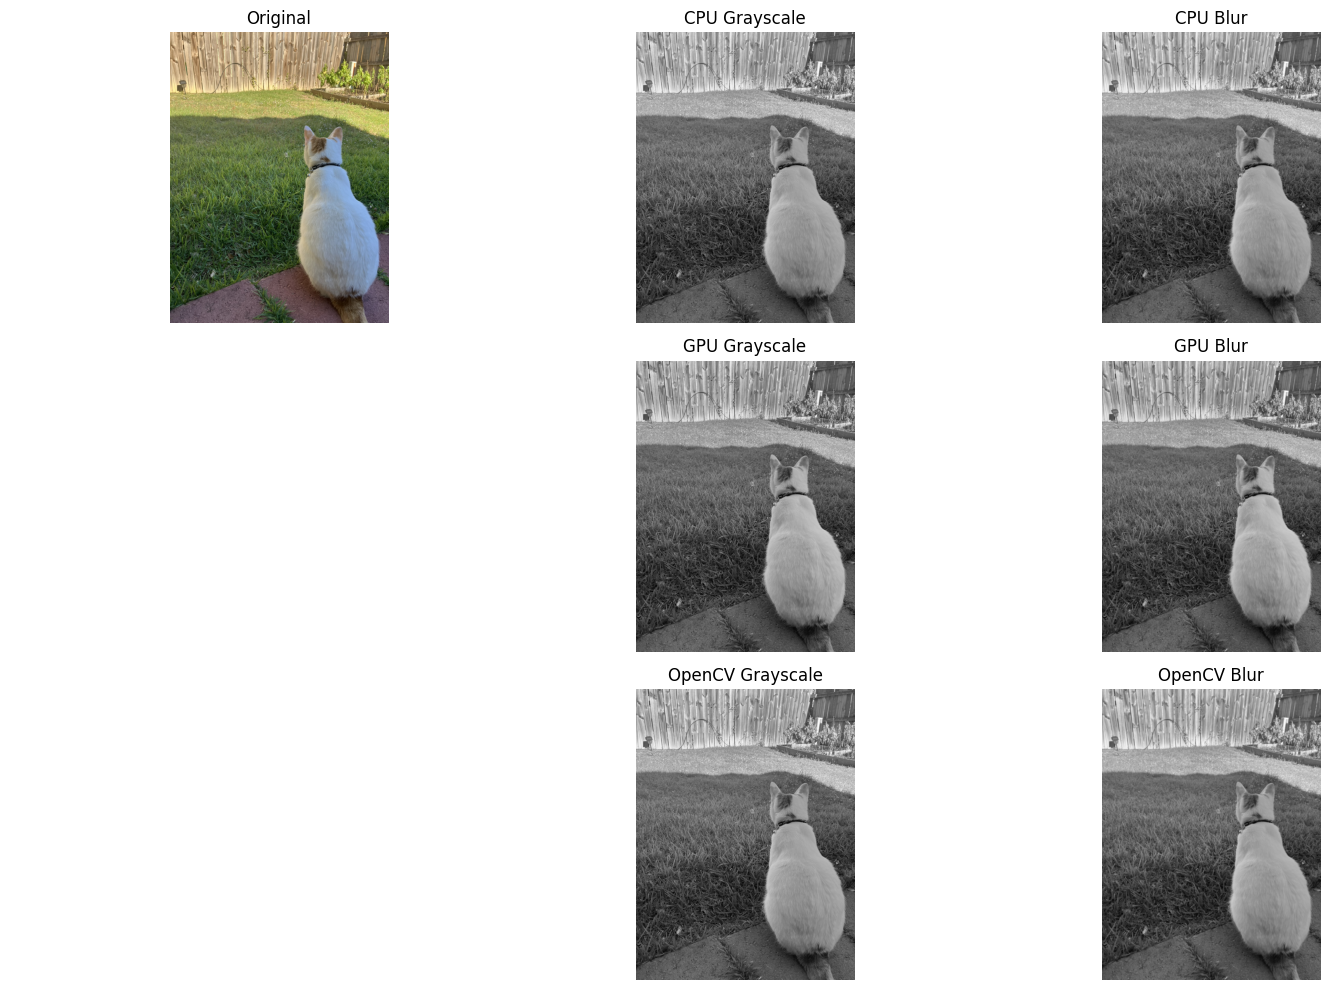

In [54]:
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# Original image
original = cv2.imread('/content/drive/MyDrive/sample.png')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
axes[0,0].imshow(original)
axes[0,0].set_title('Original')
axes[0,0].axis('off')

# CPU results
cpu_gray = cv2.imread('/content/drive/MyDrive/cpu_grayscale.png')
cpu_gray = cv2.cvtColor(cpu_gray, cv2.COLOR_BGR2GRAY)  # Convert to actual grayscale
axes[0,1].imshow(cpu_gray, cmap='gray')
axes[0,1].set_title('CPU Grayscale')
axes[0,1].axis('off')

cpu_blur = cv2.imread('/content/drive/MyDrive/cpu_blur.png')
cpu_blur = cv2.cvtColor(cpu_blur, cv2.COLOR_BGR2GRAY)
axes[0,2].imshow(cpu_blur, cmap='gray')
axes[0,2].set_title('CPU Blur')
axes[0,2].axis('off')

# GPU results
gpu_gray = cv2.imread('/content/drive/MyDrive/gpu_grayscale.png')
gpu_gray = cv2.cvtColor(gpu_gray, cv2.COLOR_BGR2GRAY)
axes[1,1].imshow(gpu_gray, cmap='gray')
axes[1,1].set_title('GPU Grayscale')
axes[1,1].axis('off')

gpu_blur = cv2.imread('/content/drive/MyDrive/gpu_blur.png')
gpu_blur = cv2.cvtColor(gpu_blur, cv2.COLOR_BGR2GRAY)
axes[1,2].imshow(gpu_blur, cmap='gray')
axes[1,2].set_title('GPU Blur')
axes[1,2].axis('off')

axes[1,0].axis('off')

# OpenCV results
opencv_gray = cv2.imread('/content/drive/MyDrive/opencv_grayscale.png')
opencv_gray = cv2.cvtColor(opencv_gray, cv2.COLOR_BGR2GRAY)
axes[2,1].imshow(opencv_gray, cmap='gray')
axes[2,1].set_title('OpenCV Grayscale')
axes[2,1].axis('off')

opencv_blur = cv2.imread('/content/drive/MyDrive/opencv_blur.png')
opencv_blur = cv2.cvtColor(opencv_blur, cv2.COLOR_BGR2GRAY)
axes[2,2].imshow(opencv_blur, cmap='gray')
axes[2,2].set_title('OpenCV Blur')
axes[2,2].axis('off')

axes[2,0].axis('off')

plt.tight_layout()
plt.show()